In [1]:
import pdb
import configparser
import gc
import glob
import matplotlib.cm as cm
import matplotlib.patches as patches
import matplotlib.font_manager as fm
import collections
import astropy.io.fits as pf
import os
import sys
import subprocess as S
import numpy as np
#matplotlib.use('Pdf')

import lsst.afw.display as afwDisplay
import numpy as np
import pylab as plt
import astropy.io.fits as pf
import lsst.afw.image as afwImage
from matplotlib.backends.backend_pdf import PdfPages



In [2]:
def array_to_dm_image (array, width, height):
    exp= afwImage.ExposureF(width, height) 
    exp.image.array[:] = array
    return exp

In [3]:
data_dir = "/project/plazas/PPL/H4RG/data/2021-02-18/"

In [4]:
# Read files
list_of_darks_ppl = data_dir + "darks/*.fits"
list_of_flats_ppl = data_dir + "flats/*.fits"
list_of_spots_ppl = data_dir + "spots/*.fits"

files = glob.glob(list_of_darks_ppl)
files_darks = sorted(files)

files = glob.glob(list_of_spots_ppl)
files_spots = sorted(files)

files = glob.glob(list_of_flats_ppl)
files_flats = sorted(files)

In [5]:
# Use one spot fits cube (single file; a "ramp") to read the frame time and number of frames.
# For these data (PPL: 2021-02-18), we expect 10 frames per ramp.
framtime = pf.open(files_spots[1])[0].header['FRAMTIME']
nFrames =  pf.open(files_spots[1])[0].header['NFRAMES']
expTimes = np.array([i*framtime for i in range(nFrames)])
print (expTimes)

[    0.       2729.90632  5459.81264  8189.71896 10919.62528 13649.5316
 16379.43792 19109.34424 21839.25056 24569.15688]


In [6]:
# Open all the ramps (might take several minutes...)
allDarks, allFlats, allSpots = [], [], []
assert len(files_darks) == len(files_flats)
assert len(files_flats) == len(files_spots)
print (len(files_flats))
counter=0
for (i,j,k) in zip(files_darks, files_flats, files_spots):
    allDarks.append(pf.open(i)[0].data)
    allFlats.append(pf.open(j)[0].data)
    allSpots.append(pf.open(k)[0].data)
    counter+=1
    #print (counter)
    #if counter == 5:
    #    break
allDarks = 2**16 - 1 - np.array(allDarks)
allSpots = 2**16 - 1 -  np.array(allSpots)
allFlats = 2**16 - 1 -  np.array(allFlats)

50


In [8]:
# Read master dark (median over ramps)
# Produced with np.median (allDarks, axis=0)  ("allDarks" before flipping values; unlike in the previous cell)
dirOutFitsMedian = "/project/plazas/PPL/H4RG/data/stacked_files/"
# Flip values
medianDarks = 2**16 - 1 - pf.open(dirOutFitsMedian + "2021APR14-median-stacked-darks-PPL-2021-02-18.fits")[0].data

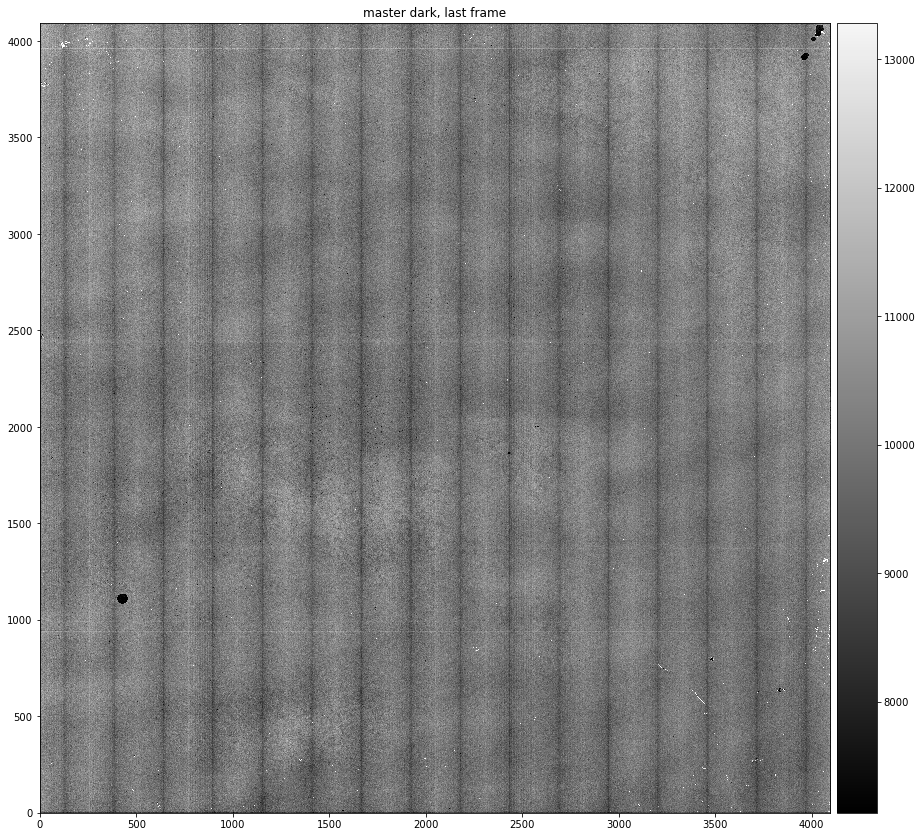

In [9]:
# Look at the last frame of the median dark ramp
newFrame = medianDarks[-1]

fig= plt.figure(figsize=(15,15))
afwDisplay.setDefaultBackend('matplotlib')
disp= afwDisplay.Display(fig)
disp.scale('asinh', 'zscale', Q=0.5)
im = array_to_dm_image (newFrame, newFrame.shape[1], newFrame.shape[0])
disp.mtv(im, title='master dark, last frame')

In [10]:
print (allSpots.shape, medianDarks.shape)

(50, 10, 4096, 4096) (10, 4096, 4096)


In [11]:
# subtract stacked dark ramp from each spot ramp (might take some time)
# Vales of both spots and median darked are already flipped
allSpots = [ramp - medianDarks for ramp in allSpots]


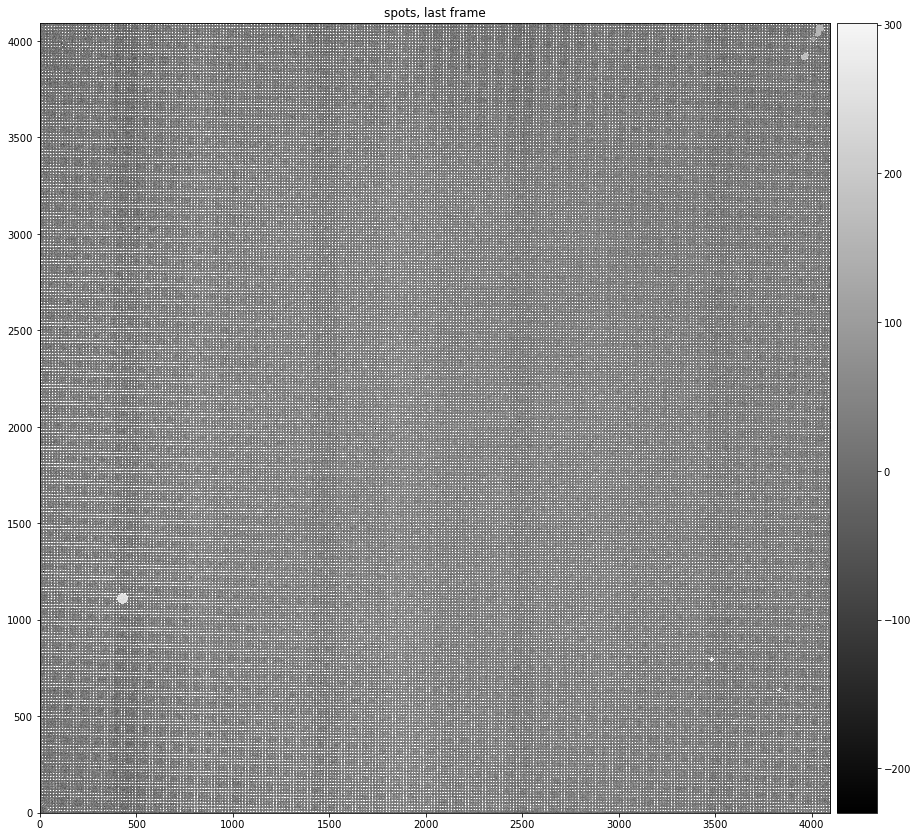

In [14]:
# Look at one ---> (Note: negative values after subtracting stacked darks?)
# maybe from the pixels taht are not spots; need to keep this in mind
newFrame = allSpots[7][-1]

fig= plt.figure(figsize=(15,15))
afwDisplay.setDefaultBackend('matplotlib')
disp= afwDisplay.Display(fig)
disp.scale('asinh', 'zscale', Q=0.5)
im = array_to_dm_image (newFrame, newFrame.shape[1], newFrame.shape[0])
disp.mtv(im, title='spots, last frame')

In [15]:
# Read spots centroids
# File produced by running Source Extractor on last frame of median-stacked spots ramp
# Source Extractor identifies ~ 700000 objects (under the given detection paremters); is this consistent with the spots expetec given the mask used at the PPL?
# Then, for each spot, an unweighted centroid is calculated (via second moments of the flux). We use those for which the magnitude of the centroid is < 0.1 pix
# After this cut, about 3100 spots are left. 
centroidData = np.genfromtxt("./selected_positions_centroid-2021APR26-3000spots.dat")

In [75]:
import sigma_clip # From Erin (Sheldon), I think
def plotCoeffsMatrix (coeffs, pdfPages=None, title='', sigmaCut=3, 
                      figSizeX=15, figSizeY=15,
                      nIter=5):
    """Make a histogram and a 2D plot of NL-correction coefficients
    
    Parameters
    ----------
    coeffs : `numpy.array`
        Matrix of NL correction coefficients.
    
    pdfPages : `matplotlib.backends.backend_pdf`
        Object to save plots in PDF file, optional
    
    sigmaCut : `float`, optional
        Sigma clipping value
    
    figSizeX : `float`, optionsl
        Fig. size
        
    figSizeY : `float`, optionsl
        Fig. size
    
    nIter : `int`
        Iterations for sigma clipping
    """
    fig = plt.figure(figsize=(figSizeX ,figSizeY ))
    sigmaCut = sigmaCut
    meanCoeffs, scatterCoeffs, mask = sigma_clip.sigma_clip(coeffs.flatten(), niter=nIter, 
                                                   nsig=sigmaCut, get_indices=True)
    print ("Mean and std: ", meanCoeffs, scatterCoeffs)
    medianCoeffs = np.median(coeffs)
    print ("Median: ", medianCoeffs)
    prop = fm.FontProperties(size=10)
    loc_label = 'upper right'
    
    ax=fig.add_subplot(111)
    plt.imshow(coeffs, cmap='viridis', interpolation='nearest', origin='lower',
               vmin=medianCoeffs - sigmaCut*medianCoeffs,
               vmax=medianCoeffs + sigmaCut*medianCoeffs)
    plt.colorbar()
    #ax.set_title (r"correction coeff", size=11)
    fig.suptitle(title)
    if pdfPages:
        pdfPages.savefig()

    fig = plt.figure(figsize=(figSizeX ,figSizeY))
    ax = fig.add_subplot(111)
    
    #w = 3
    #nBins = math.ceil((coeffs.max() - coeffs.min())/w)
    
    n, bins, patches_out = ax.hist(coeffs.flatten()[mask], 100, facecolor='red',
            alpha=0.7, label=f"Mean (sigma clip.): {meanCoeffs:.4e} \n Median (numpy): {medianCoeffs:.4e} \n Scatter (sigma clip): {scatterCoeffs:.4e}")
    ax.set_title('Histogram after %g-sigma clipping' %sigmaCut, size=10)
    ax.legend(loc=loc_label , fancybox=True, ncol=1, numpoints=1, prop = prop)
    ax.tick_params(axis='both', which='major', labelsize=11.5)
    fig.suptitle(title)
    if pdfPages:
        pdfPages.savefig()

In [17]:
# Read C2 and C3 matrices to correct for classical non-linearity  (might take some time; ~16e6 coeffs per matrix)
# Produced with https://github.com/plazas/bf_hxrg_ppl/blob/master/NL_correction_fits_from_median_flat.py from master flats
c2MatrixFile = "/project/plazas/PPL/H4RG/bf_hxrg_ppl/output/NL_C2_Coeffs_2021APR14.dat"
c3MatrixFile = "/project/plazas/PPL/H4RG/bf_hxrg_ppl/output/NL_C3_Coeffs_2021APR14.dat"
c2Matrix = np.genfromtxt (c2MatrixFile)
c3Matrix = np.genfromtxt (c3MatrixFile)


Mean and std:  8.954281222673674e-07 1.2716245133246695e-06
Median:  8.985655499719271e-07
Mean and std:  -7.119930323698963e-06 0.00021132377038968675
Median:  1.3086318258765325e-11


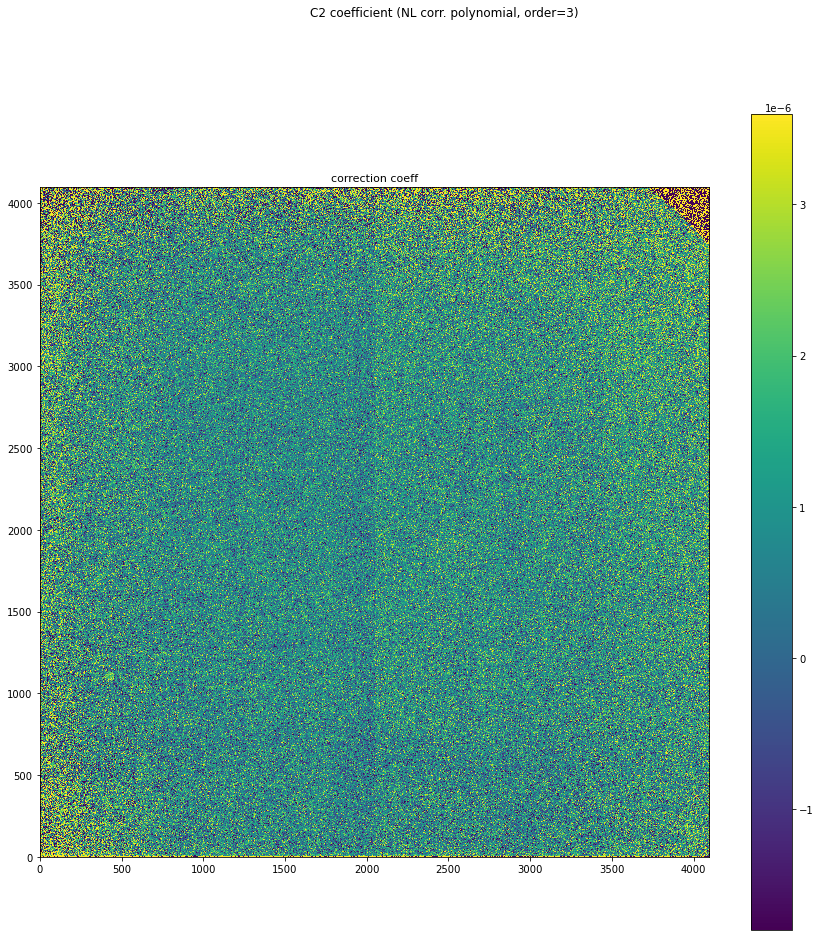

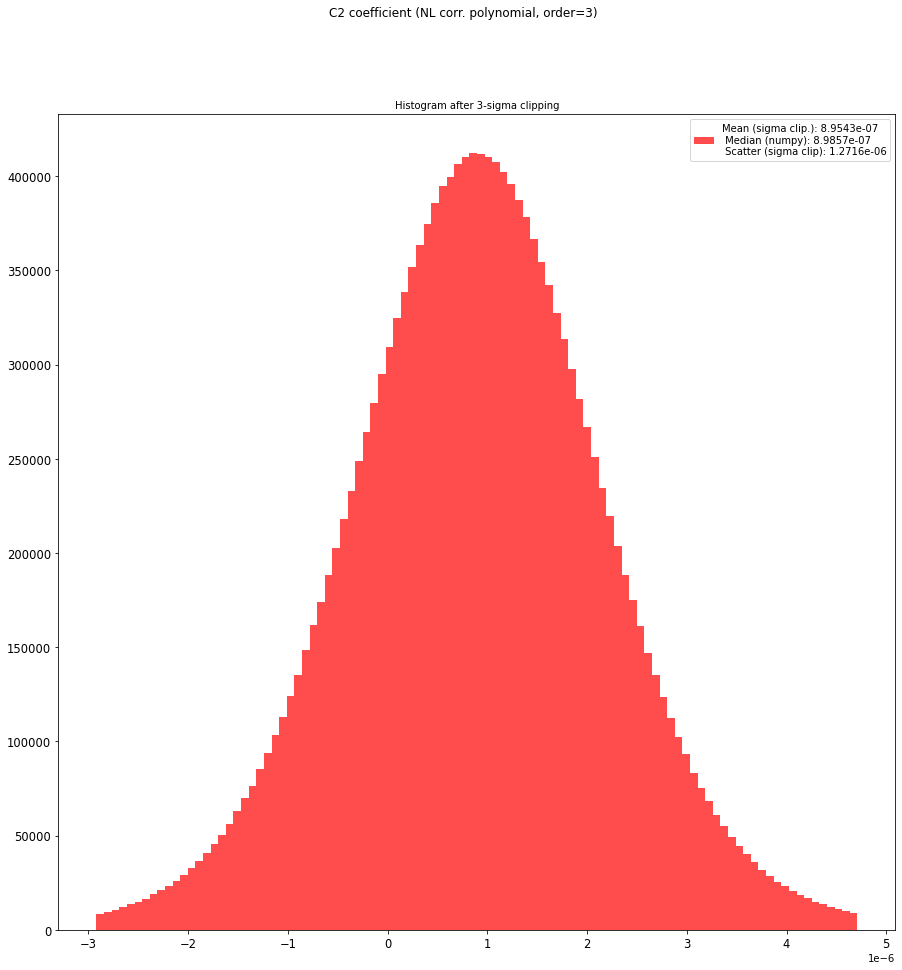

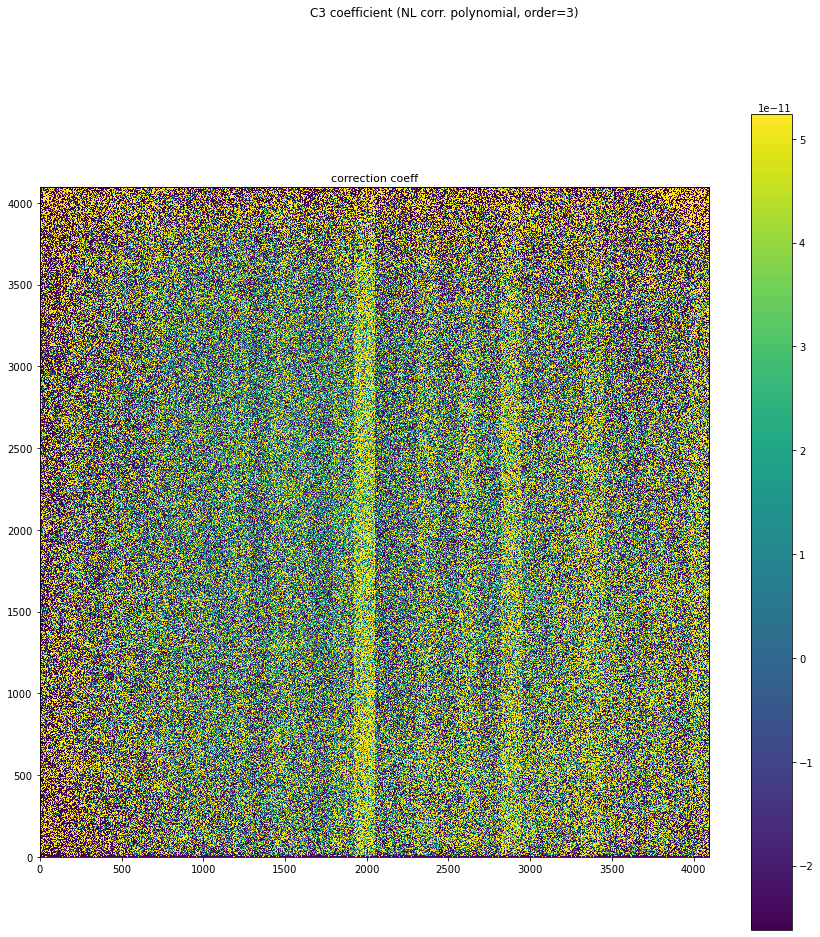

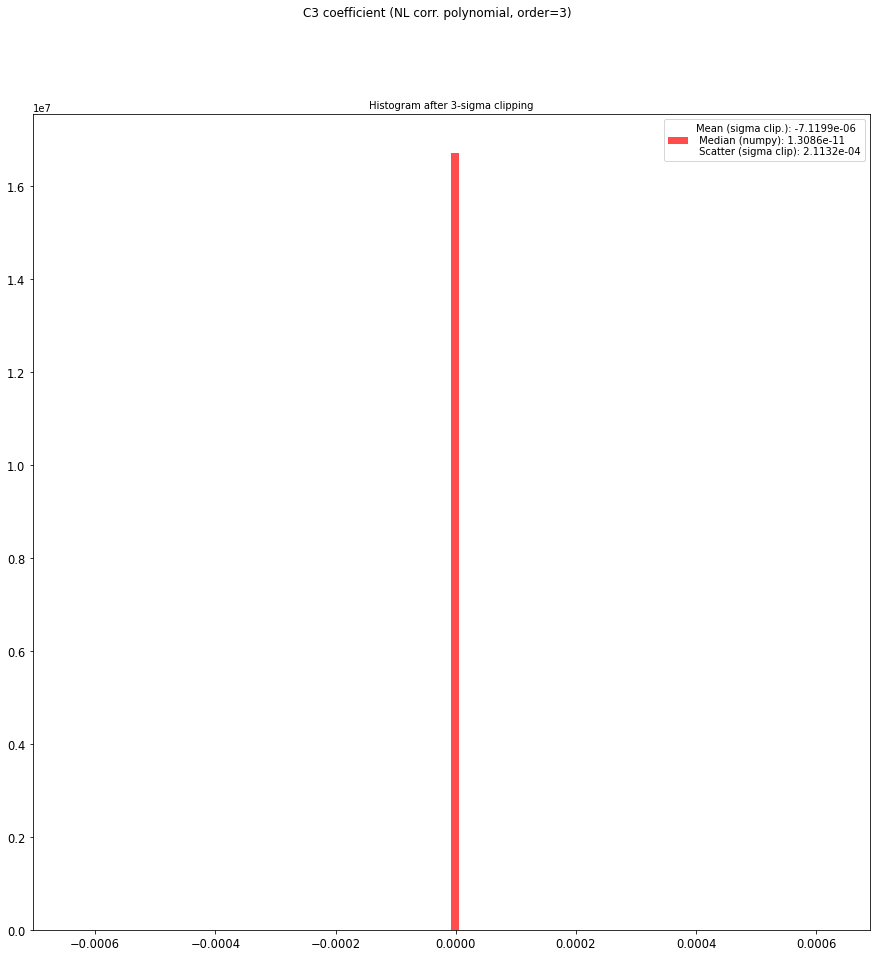

In [20]:
plotCoeffsMatrix (c2Matrix, title="C2 coefficient (NL corr. polynomial, order=3)", sigmaCut=3.0)
plotCoeffsMatrix (c3Matrix, title="C3 coefficient (NL corr. polynomial, order=3)", sigmaCut=3.0)

In [21]:
# Define these functions to fit a line to the central pixel of the spots. The (negative) slope will be related to B; see Plazas+17
from scipy import optimize
def fitfunc_m(x, m):
    # x=np.array(x)
    return m*x

def linear_fit_m(x, y, y_err):
    pinit = [-0.001]
    pfinal, covar = optimize.curve_fit(
        fitfunc_m, x, y, p0=pinit, sigma=y_err,  maxfev=100000)
    return pfinal[0], np.sqrt(covar[0])

In [154]:
# function to calculate B given a spot center and a ramp
deltaTime = 2729.90632/1e3 # Divide by 1e3 to get seconds pf.open(allSpots[1])[0].header['FRAMTIME']
def getB (xc, yc, spotRamp, firstFrame=1):
    # Create a 3by3 postage stamp ramp (i.e., shape=(Nframes, 3, 3)) of spot centered at (yc, xc)
    stampRamp = spotRamp [:, yc-1:yc+2, xc-1:xc+2]
    
    # Discard first frame(s), usually just the 0th frame, so start at frame=1.
    stampRamp = stampRamp[firstFrame:]
    
    #print ("xc, yc", xc, yc)
    #print ('Before', stampRamp[-1])
    # Correct for NL
    stampRamp = correctNL(stampRamp, xc=xc, yc=yc)
    #if xc == 3542:
    #print ('After center', stampRamp[-1])
    
    rates = np.diff(stampRamp, axis=0)/deltaTime
    val0 = rates[0, 1, 1] # for central pixel, first flux value (F_1 in paper)
    rates -= rates[0]
    
    # normalization factor, F_* in the paper
    stampNorm = np.sum (stampRamp[-1] - stampRamp[0])/ ( (nFrames-2)*deltaTime)
    rates /= stampNorm
    
    # Fit a line to frame number vs normalized rates in the central pixel
    # Eq. 10 of Plazas+17

    m, m_err = linear_fit_m (range(len(rates[:, 1, 1])), rates[:, 1, 1], None)
    #print ("m, m_err ", m, m_err )
    
    # The B coefficient and the slope "m" are related to each other by Eq. 11 of Plazas+17
    # Fc: this contrast is calculated from the fluxes in the central pixel and its four nearest neighbors in the stamp ramp. 
    # So, fit a quadratic polynomial
    # to each pixel ramp and get the linear parameter as the flux
    #print (expTimes[firstFrame:], stampRamp[:, 1, 1])
    
    par, _= np.polyfit (expTimes[firstFrame:]/1000, stampRamp[:, 1, 1], deg=2, cov=True)
    fluxCenter = par[1]
    
    par, _= np.polyfit (expTimes[firstFrame:]/1000, stampRamp[:, 1, 2], deg=2, cov=True)
    fluxTop = par[1]
    
    par, _= np.polyfit (expTimes[firstFrame:]/1000, stampRamp[:, 1, 0], deg=2, cov=True)
    fluxBottom = par[1]
    
    par, _= np.polyfit (expTimes[firstFrame:]/1000, stampRamp[:, 0, 1], deg=2, cov=True)
    fluxLeft = par[1]
    
    par, _= np.polyfit (expTimes[firstFrame:]/1000, stampRamp[:, 2, 1], deg=2, cov=True)
    fluxRight = par[1]
    
    # Contrast
    fc = fluxCenter - (fluxTop + fluxBottom + fluxLeft + fluxRight)*0.25
    
    #print (fluxCenter, fluxTop, fluxBottom, fluxLeft, fluxRight)
    #print (m, fc, stampNorm, )
    # Eq. 11
    try:
        B = (m/fc)*(stampNorm/(val0*deltaTime))
    except RuntimeWarning:
        print ("STOP: ")
        print ("B, m, fc, stampNorm, val0", B, m, fc, stampNorm, val0)
        stop
        
    #print ("B: ", B)    
    #stop
    return B, m, fc, stampNorm, val0

In [155]:
# Function to correct for NL (cubic polynomial), given C2 and C3 matrices
# From https://github.com/plazas/bf_hxrg_ppl/blob/master/correct_NL.py
def correctNL (medianImageCube, xc=None, yc=None):
    """
    Parameters
    ----------
    medianImageCube : `numpy.array`
         Ramp to correct: numpy array of the form 
         (Nframes, detSizeX, detSizeY).
         SUTR data be corrected for classical NL.
    
    xc : `int`, optional
        xc for spot center
        
    yc : `int`, optional
        yc for spot center
        
    Returns
    -------
    correctedImageCube : `numpy.array`
        Corrected ramp (after applying polynomial NL 
        correction as in Freudenburg+20; 2003.05978)
    
    Notes
    -----
    Provide xc and yc to do the calculation just for 3 by 3 stamp. 
    If not provided, the correction might take some time (whole 4k by 4k array).
    """
    if xc and yc:
        correctionCoeffs=[c2Matrix[yc-1:yc+2, xc-1:xc+2], c3Matrix[yc-1:yc+2, xc-1:xc+2]]
    else:
        correctionCoeffs=[c2Matrix, c3Matrix]
    correction = np.zeros_like(medianImageCube)
    for order, coeff in enumerate(correctionCoeffs):
        correction+= coeff * np.power(medianImageCube, order+2)
    correctedImageCube = medianImageCube + correction
    
    return correctedImageCube

In [156]:
def plotHistogram (im, sigmaCut=3.0, figSizeX=15, figSizeY=15, nBins=50, labelSize=12, title=''):
    im= np.array(im)
    prop = fm.FontProperties(size=labelSize)
    loc_label = 'upper right'
    meanCoeffs, scatterCoeffs, mask = sigma_clip.sigma_clip(im, niter=10, 
                                                        nsig=sigmaCut, get_indices=True)
    medianCoeffs = np.median(im)
    fig = plt.figure(figsize=(figSizeX,figSizeY))
    ax = fig.add_subplot(111)

    n, bins, patches_out = ax.hist(im[mask], nBins, facecolor='red',
                                   alpha=0.7, label=f"Mean (sigma clip.): {meanCoeffs:.4e} \n Median (numpy): {medianCoeffs:.4e} \n Scatter (sigma clip): {scatterCoeffs:.4e}")
    ax.set_title('Histogram after %g-sigma clipping' %sigmaCut, size=10)
    ax.legend(loc=loc_label , fancybox=True, ncol=1, numpoints=1, prop = prop)
    ax.tick_params(axis='both', which='major', labelsize=11.5)
    fig.suptitle(title)

<ipython-input-154-f6ae3abedefd>:59: RuntimeWarning: divide by zero encountered in double_scalars
  B = (m/fc)*(stampNorm/(val0*deltaTime))


Skipp this ramp:  2458 280 -inf 0.010458281220157352 -2.7822920809052953 9.570275954654578 0.0
Skipp this ramp:  2458 280 inf -0.02803277874984913 -4.1276592247665045 12.13999242369184 0.0
Skipp this ramp:  1239 394 inf -0.03072024118128265 -4.244920505421685 13.494697018910285 0.0
Skipp this ramp:  1889 411 inf 0.03176497598843447 7.8980551357087485 16.88064722604497 0.0
Skipp this ramp:  2652 413 -inf -0.038631905448814785 10.308813498471975 11.516221499786772 0.0
Skipp this ramp:  3247 544 inf 0.04221399438981322 3.216085279382241 13.394555916561728 0.0
Skipp this ramp:  1105 679 inf -0.011288307863894441 -1.1834056763047947 20.697932023039467 0.0
Skipp this ramp:  1356 717 -inf -0.008034878651010291 1.0226977689929635 12.842253532401275 0.0
Skipp this ramp:  2793 736 inf -0.03379836771120296 -1.2863911597446451 10.306977268057185 0.0
Skipp this ramp:  983 738 inf 0.007251533203219704 2.369074928532762 38.66313184653846 0.0
Skipp this ramp:  983 738 inf 0.013950080364190284 9.230420

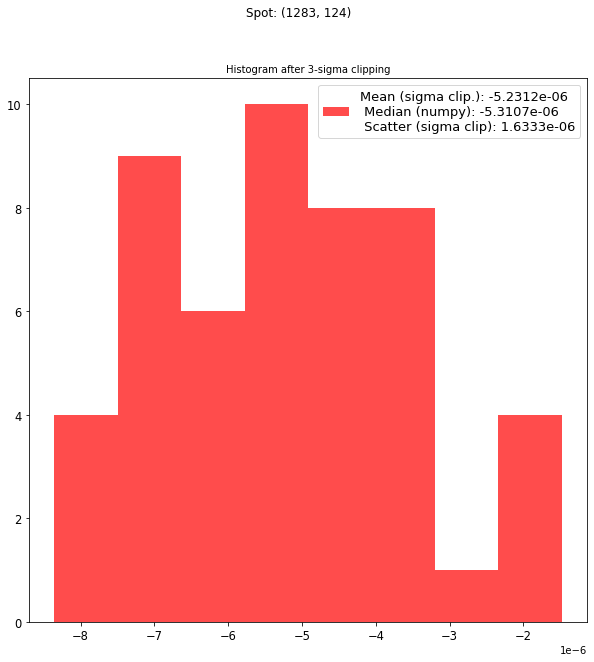

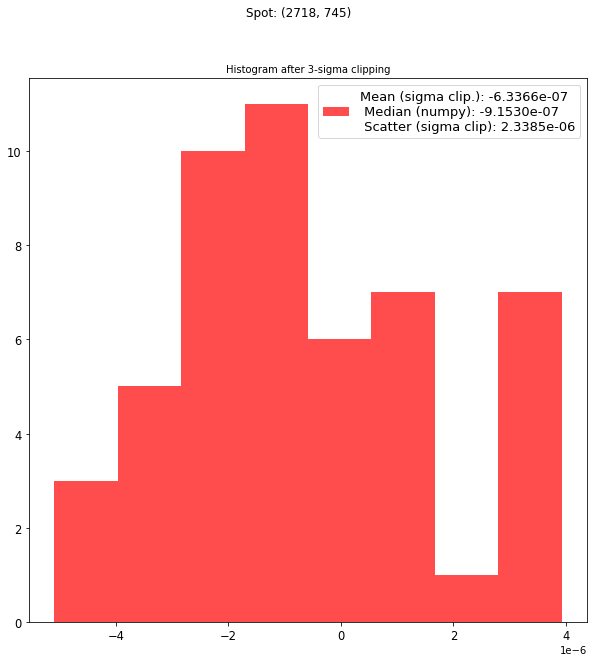

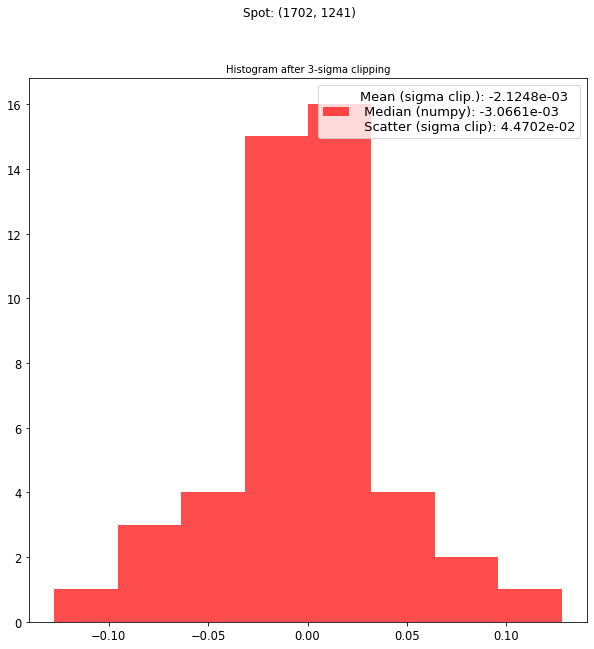

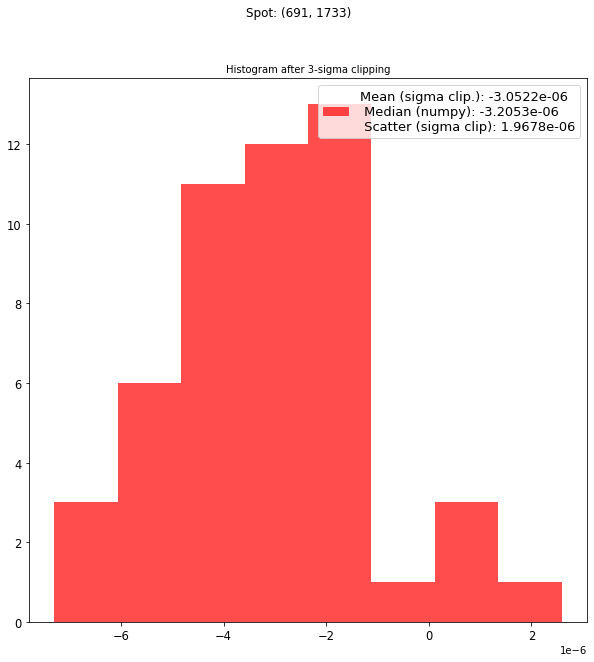

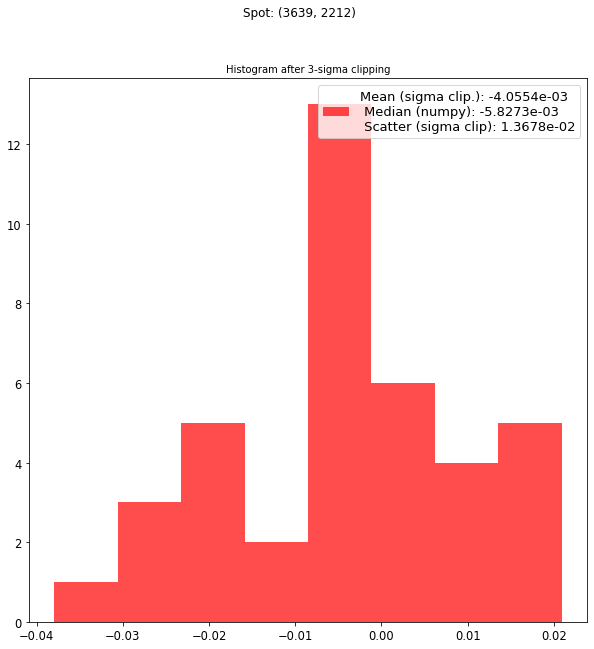

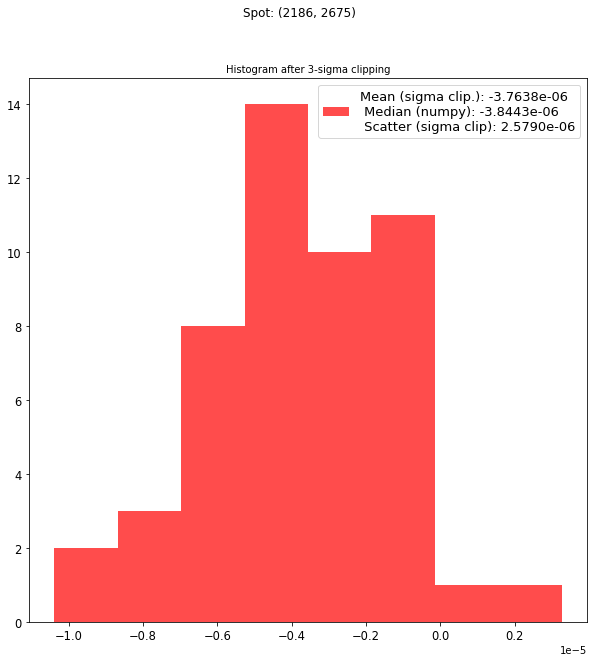

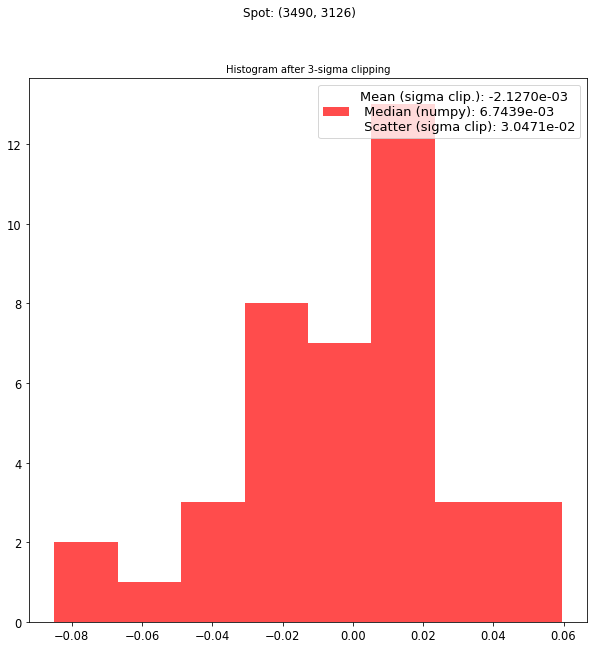

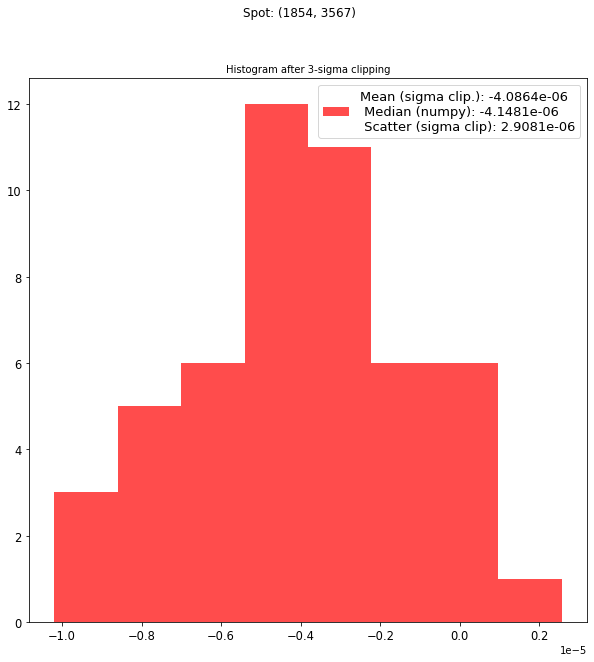

In [182]:
# Loop over spots, and for each spot's ramp (e.g., 50 ramps), calculate B (and the factors in its definition)
allSpotsMeanB, allSpotsMeanStdB = [], []
allFc, allSlope, allValZero, allStampNorm = [], [], [], []

pinf = float('+inf')
ninf = float('-inf')
fnan = float('nan') 

xVec, yVec =[],[]
maskCentroid = np.repeat(True, len(centroidData))
#maskY = np.repeat(True, len(centroidData))
counter=0
skippedCounter=0
for center in centroidData:
    xc, yc = int(center[0]),int(center[1])
    valCenter = allSpots[0][:, yc-1:yc+2, xc-1:xc+2][-1][1,1]   
    #if valCenter < 1e4:
    #    print ("Skipping valCenter:", valCenter)
    #    skippedCounter+=1
    Bvec = []
    for ramp in allSpots:
        # Correct for classical NL inside the B function
        B, m, fc, stampNorm, val0  = getB (int(center[0]),int(center[1]), ramp)
        if B in [pinf, ninf, fnan]:
            print ("Skip this ramp: ", xc, yc, B, m, fc, stampNorm, val0 )
            continue
        Bvec.append(B)
        allFc.append(fc)
        allSlope.append(m)
        allValZero.append(val0)
        allStampNorm.append(stampNorm)
    
    Bvec = np.array(Bvec)
    meanB = np.nanmean(Bvec)
    stdB = np.nanstd(Bvec)    
    if meanB in [pinf, ninf, fnan]:
        print ("Skipping: ", xc, yc, meanB, stdB)
        #maskCentroid[counter] = False
        #counter+=1
        skippedCounter+=1
        continue
 
    xVec.append(xc)
    yVec.append(yc)
    allSpotsMeanB.append(meanB)
    allSpotsMeanStdB.append(stdB)

    # Plot some histograms for a few spots (total ~ 3100)  
    if counter%400 == 0:
        plotHistogram(Bvec, figSizeX=10, figSizeY=10, nBins=8, labelSize=13, title=f"Spot: ({xc}, {yc})")
    

        

    counter+=1
    #if counter == 50:
    #    break
#print (f"Skipped {skippedCounter} spots out of {len(centroidData)}")
xVec = np.array(xVec)
yVec = np.array(yVec)

allSpotsMeanB = np.array(allSpotsMeanB)
allSpotsMeanStdB = np.array(allSpotsMeanStdB)
allFc = np.array(allFc)
allSlope = np.array(allSlope)
allValZero = np.array(allValZero)
allSpotsMeanStdB = np.array(allSpotsMeanStdB)



-4.152700069999918e-06


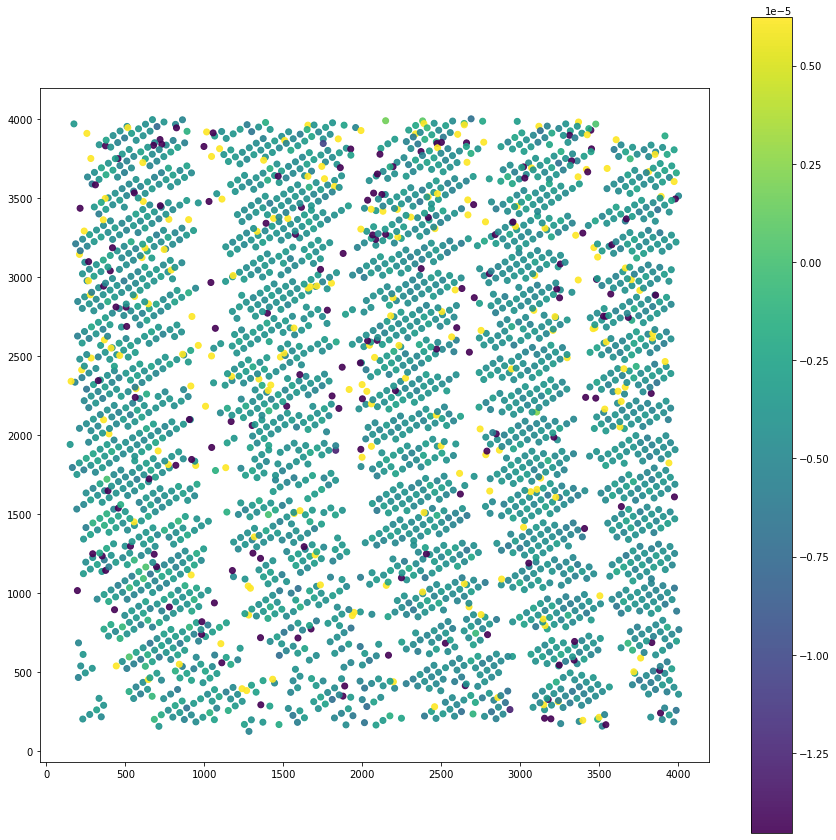

In [183]:
# Look at the mean B around the detector
medianCoeffs= np.nanmedian(allSpotsMeanB)
print (medianCoeffs)
sigmaCut=2.5

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
plt.scatter(centroidData[:,0], centroidData[:,1], c=allSpotsMeanB, 
            cmap='viridis', alpha=0.9, #, s=20,
            vmin=medianCoeffs - sigmaCut*medianCoeffs,
            vmax=medianCoeffs + sigmaCut*medianCoeffs)
ax.set_aspect(1)
plt.colorbar()


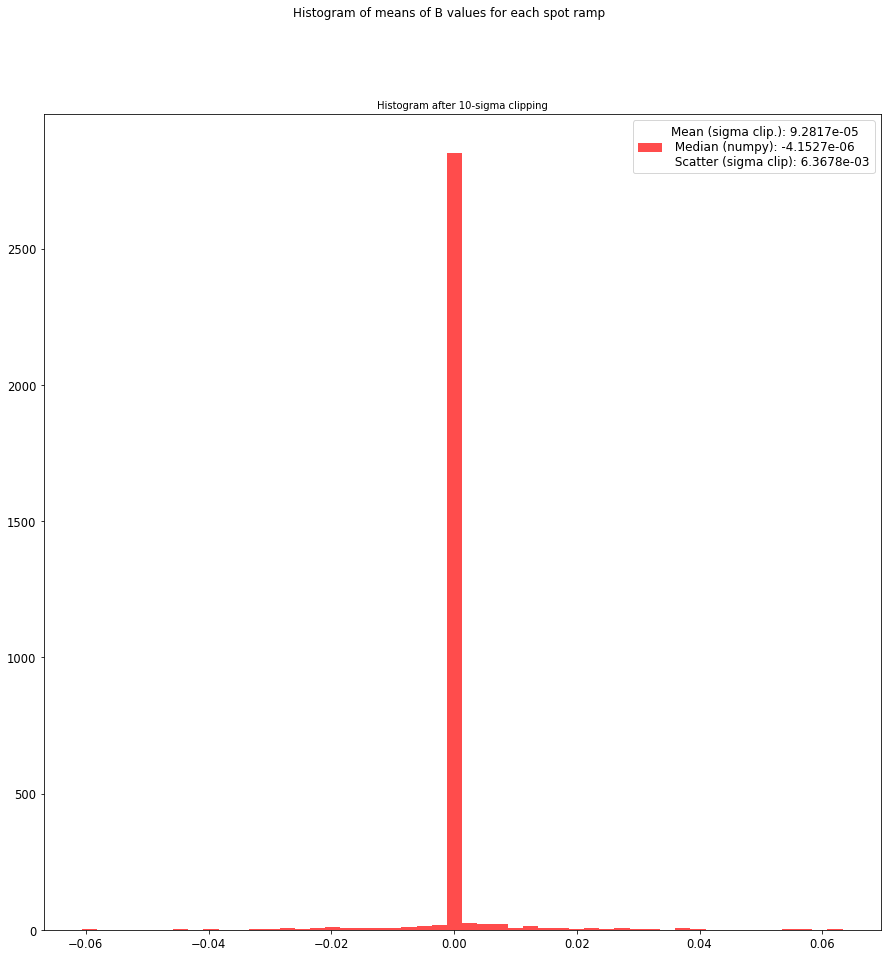

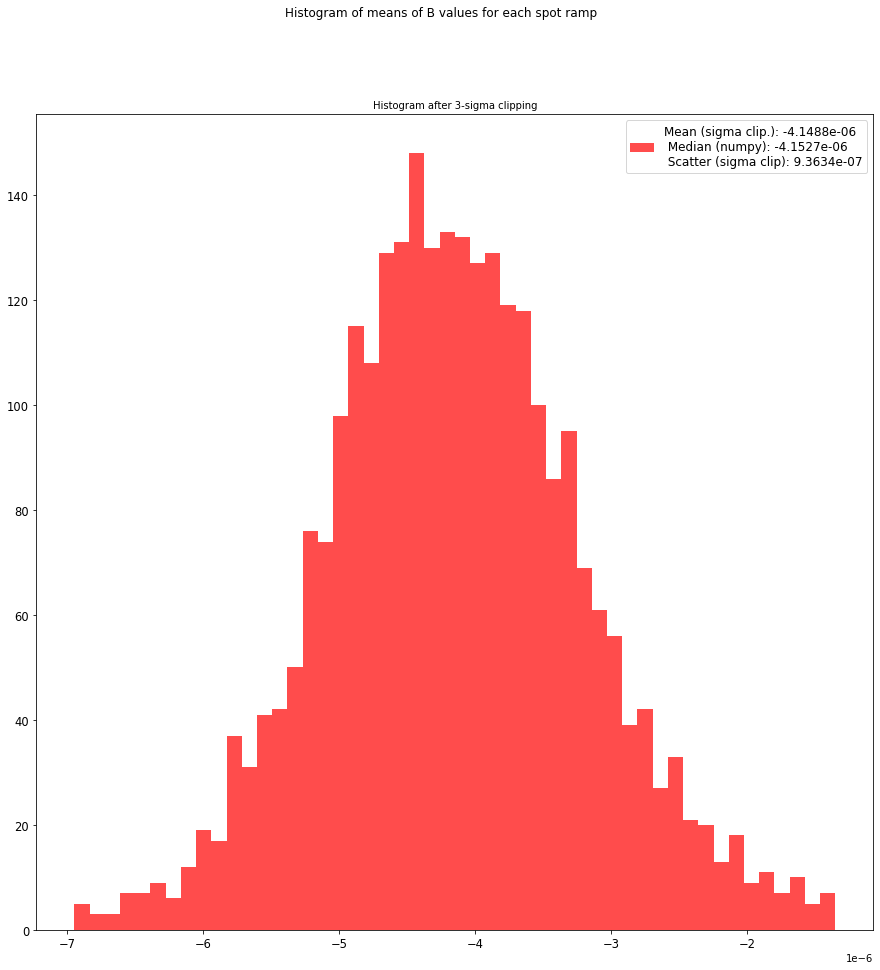

In [186]:
# Means of B
plotHistogram(allSpotsMeanB, sigmaCut=10.0, title="Histogram of means of B values for each spot ramp")
plotHistogram(allSpotsMeanB, sigmaCut=3.0, title="Histogram of means of B values for each spot ramp")


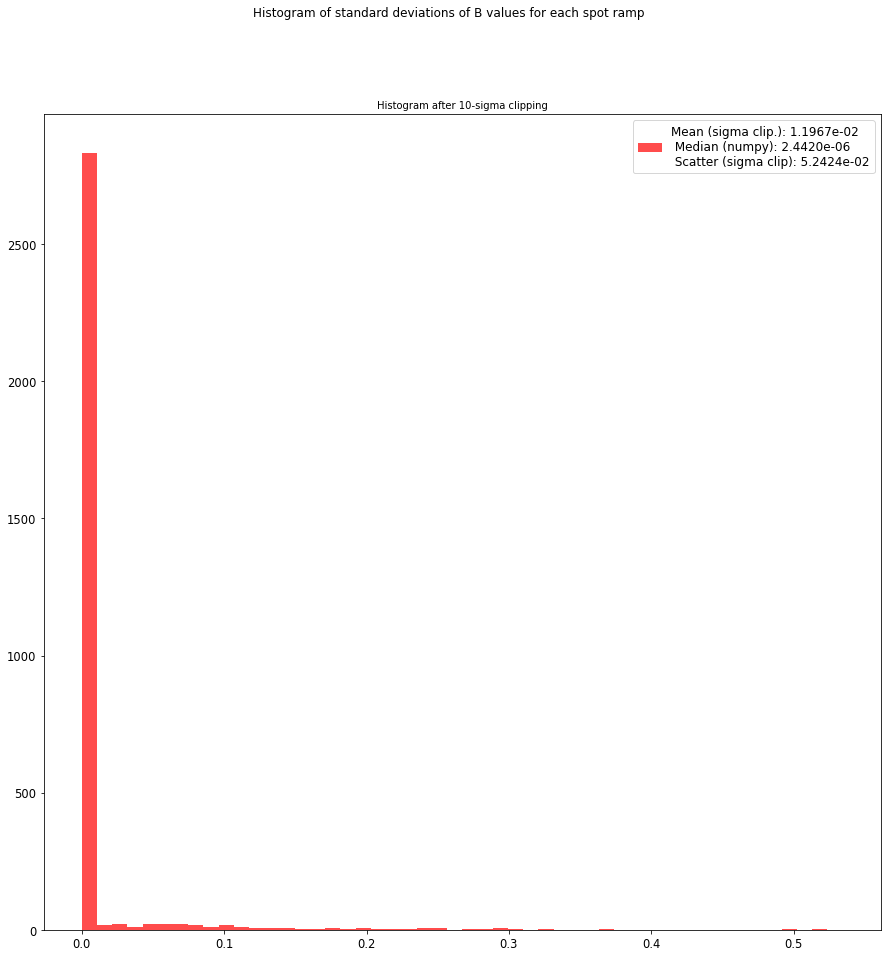

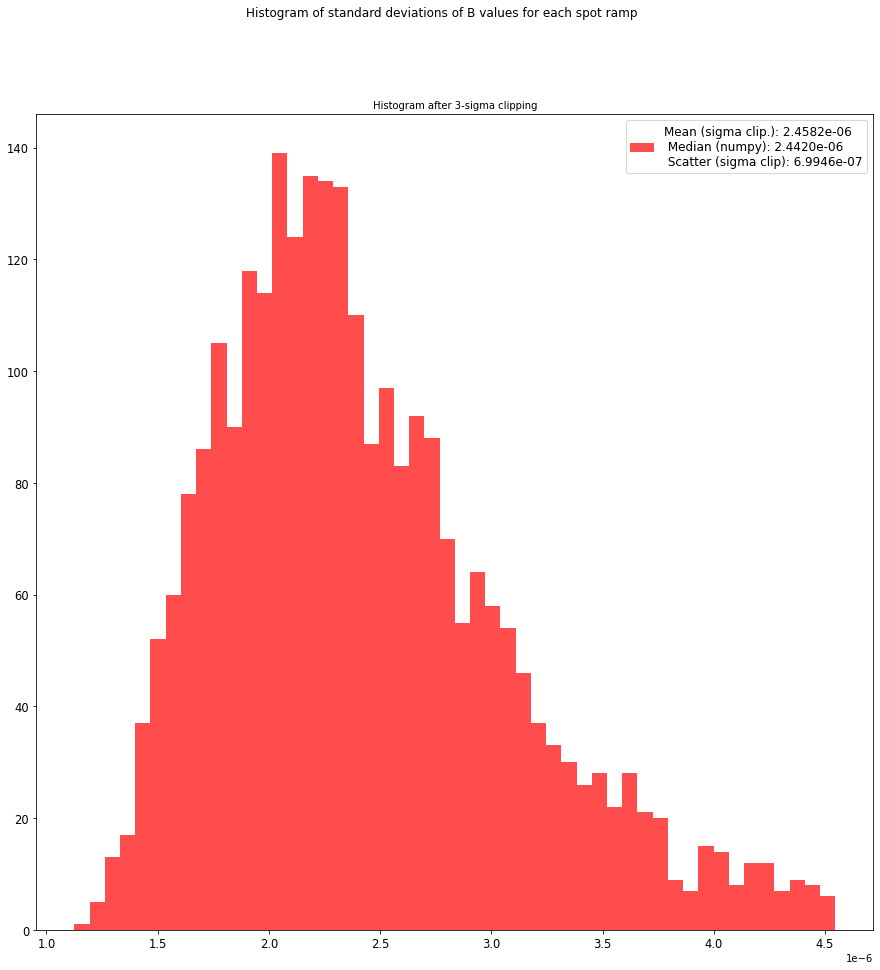

In [189]:
# Std deviations of B
plotHistogram(allSpotsMeanStdB, sigmaCut=10, title="Histogram of standard deviations of B values for each spot ramp")
plotHistogram(allSpotsMeanStdB, sigmaCut=3.0, title="Histogram of standard deviations of B values for each spot ramp")




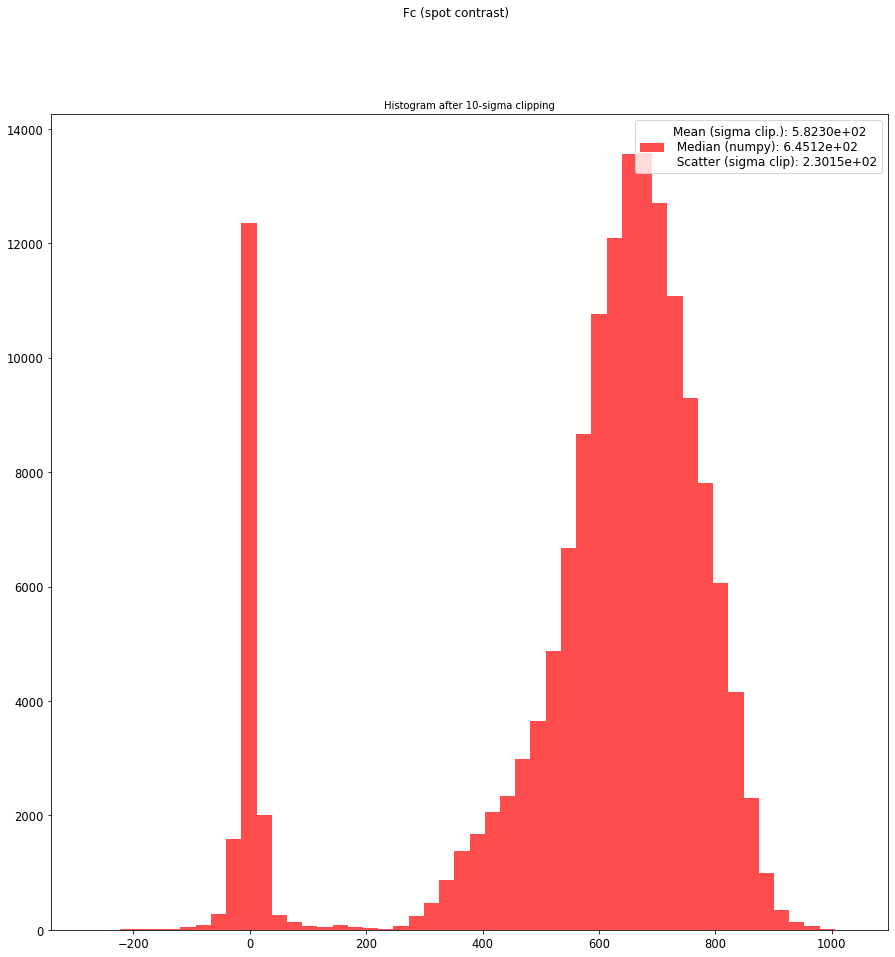

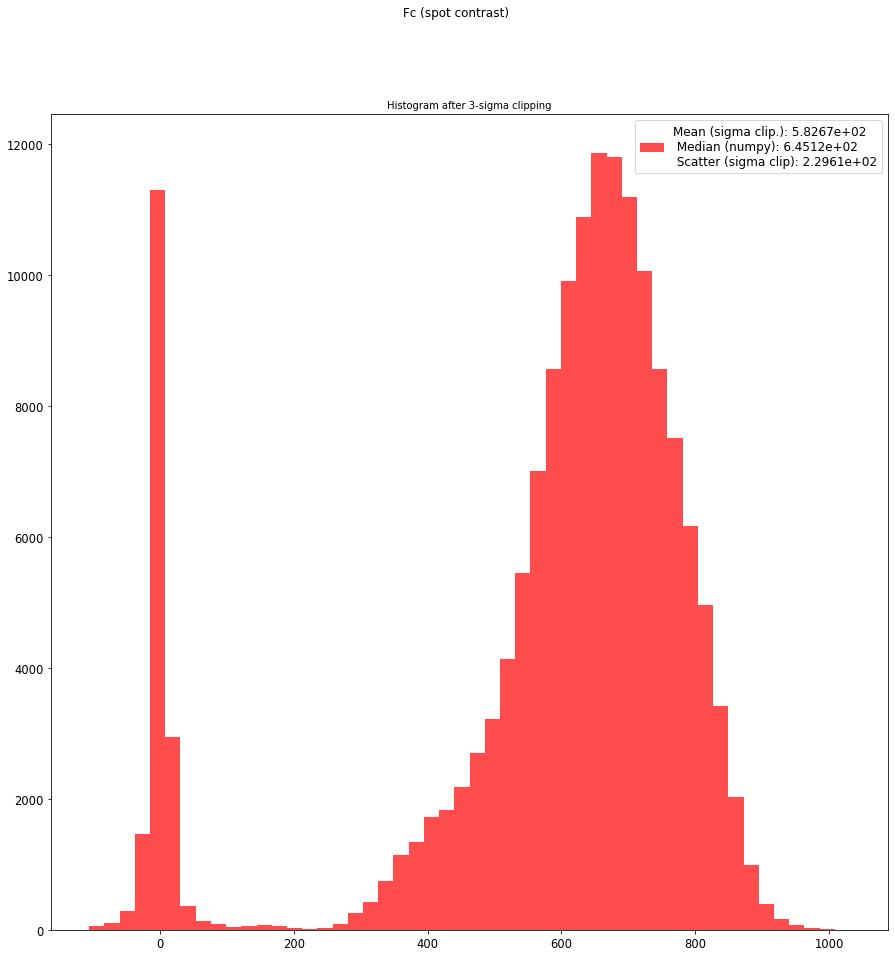

In [191]:
# Contrast...bimodal?? Maybe we want to put a cut in contrast? 
plotHistogram(allFc, sigmaCut=10.0, title="Fc (spot contrast)")
plotHistogram(allFc, sigmaCut=3.0, title="Fc (spot contrast)")

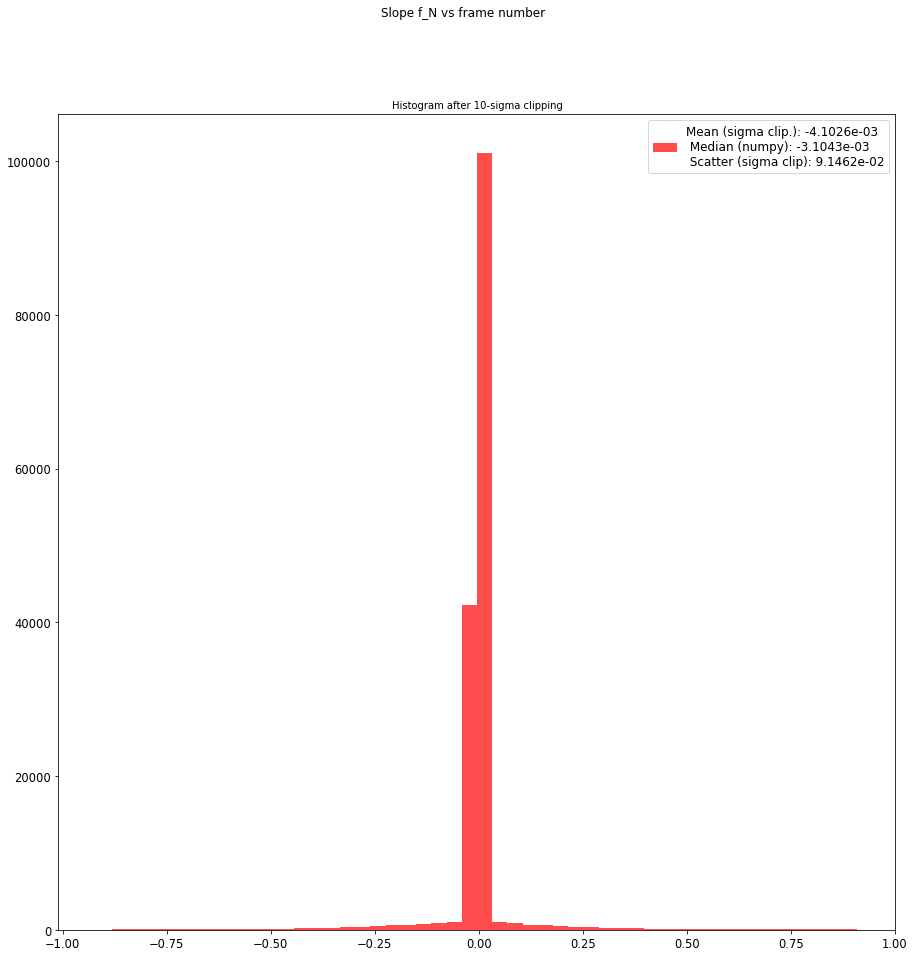

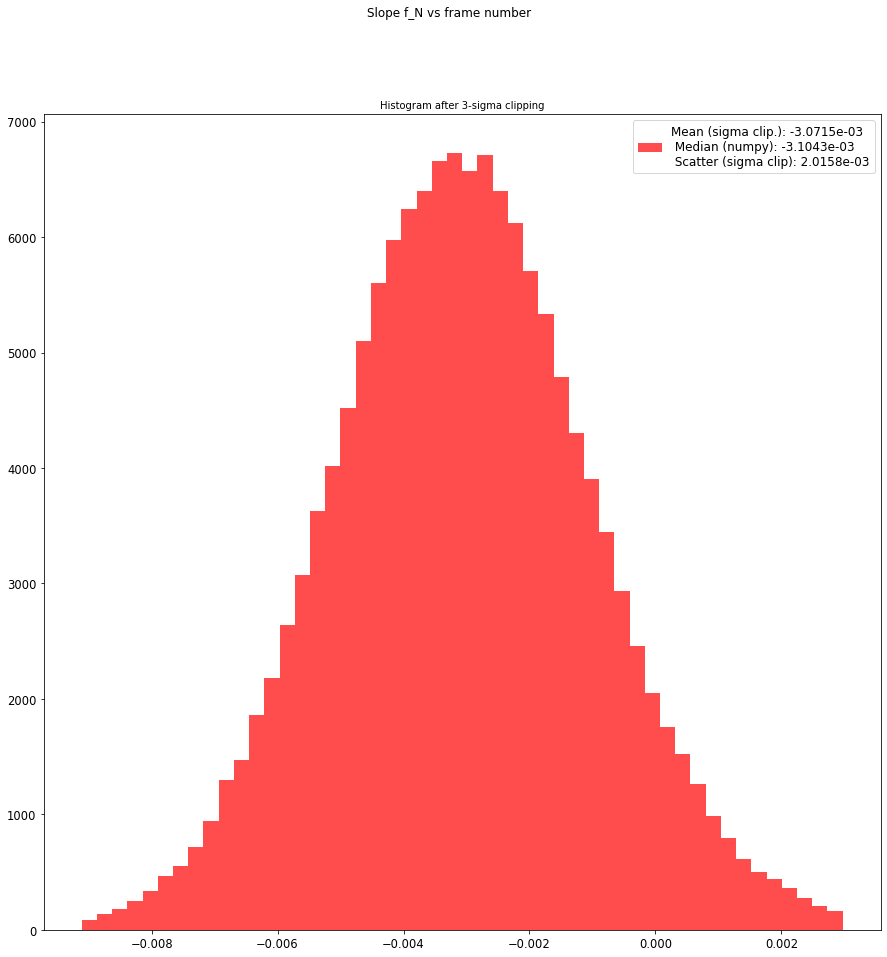

In [192]:
# m slope
plotHistogram(allSlope, sigmaCut=10.0, title="Slope f_N vs frame number")
plotHistogram(allSlope, sigmaCut=3.0, title="Slope f_N vs frame number")

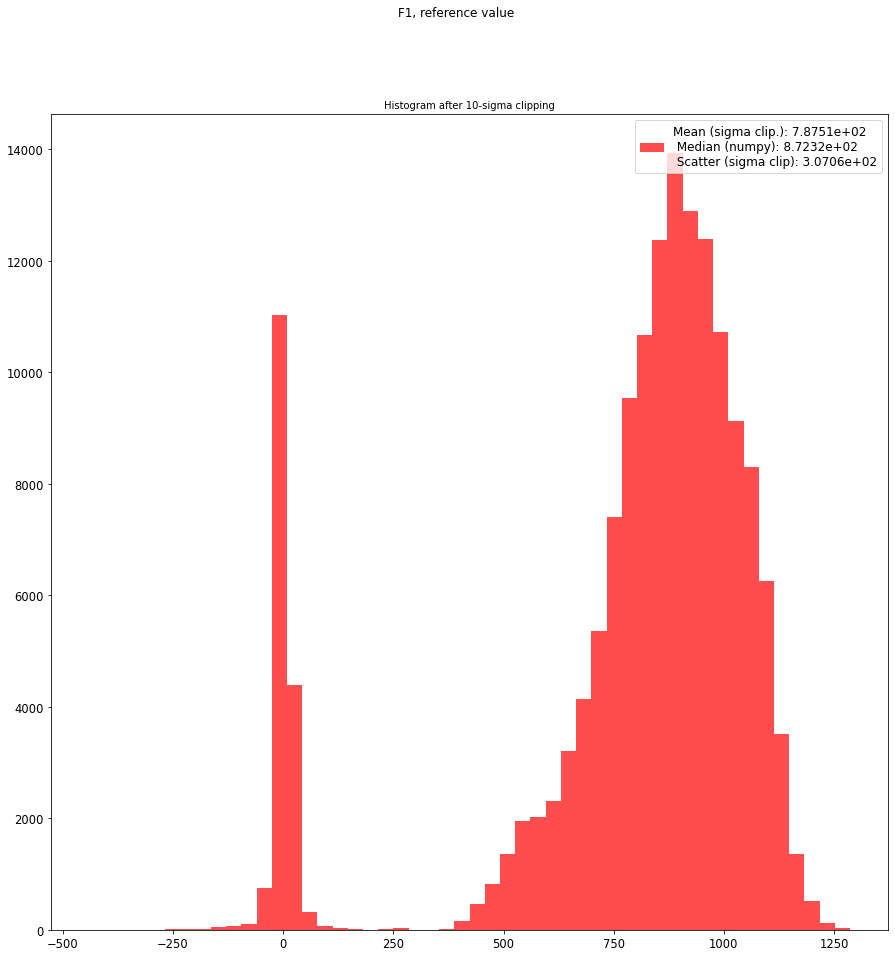

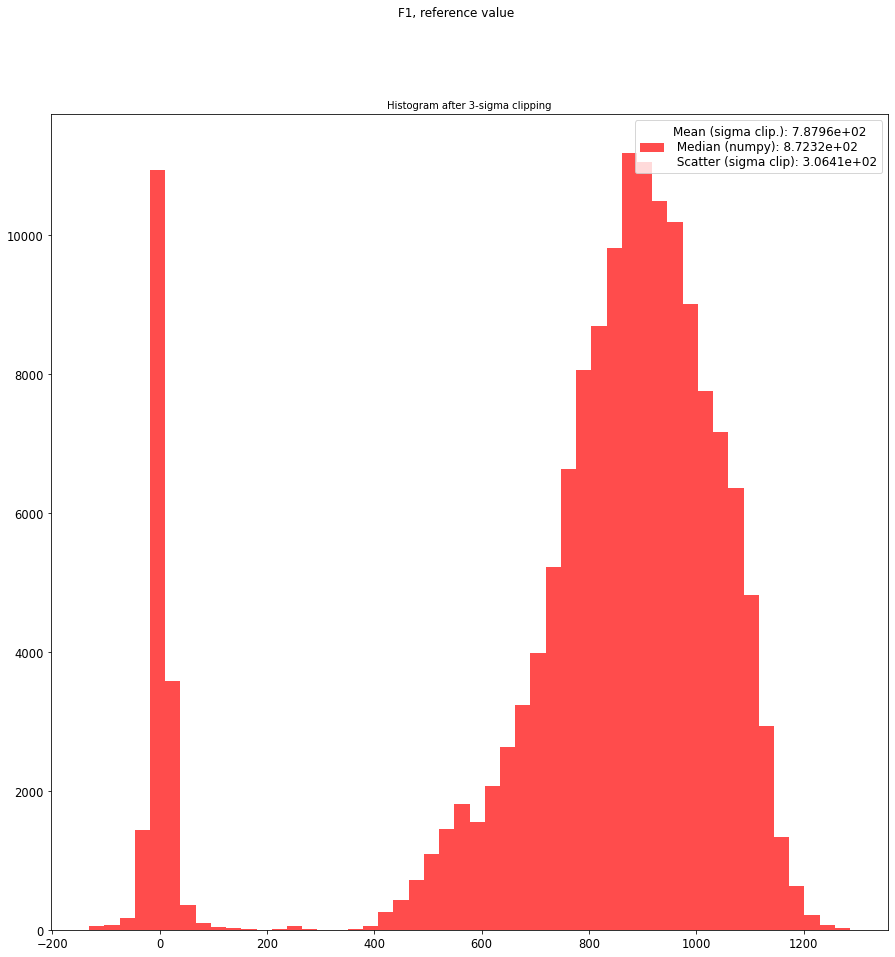

In [195]:
# Also bimodal, so two populations of spots (S/N)
plotHistogram(allValZero, sigmaCut=10.0, title="F1, reference value")
plotHistogram(allValZero, sigmaCut=3.0, title="F1, reference value")

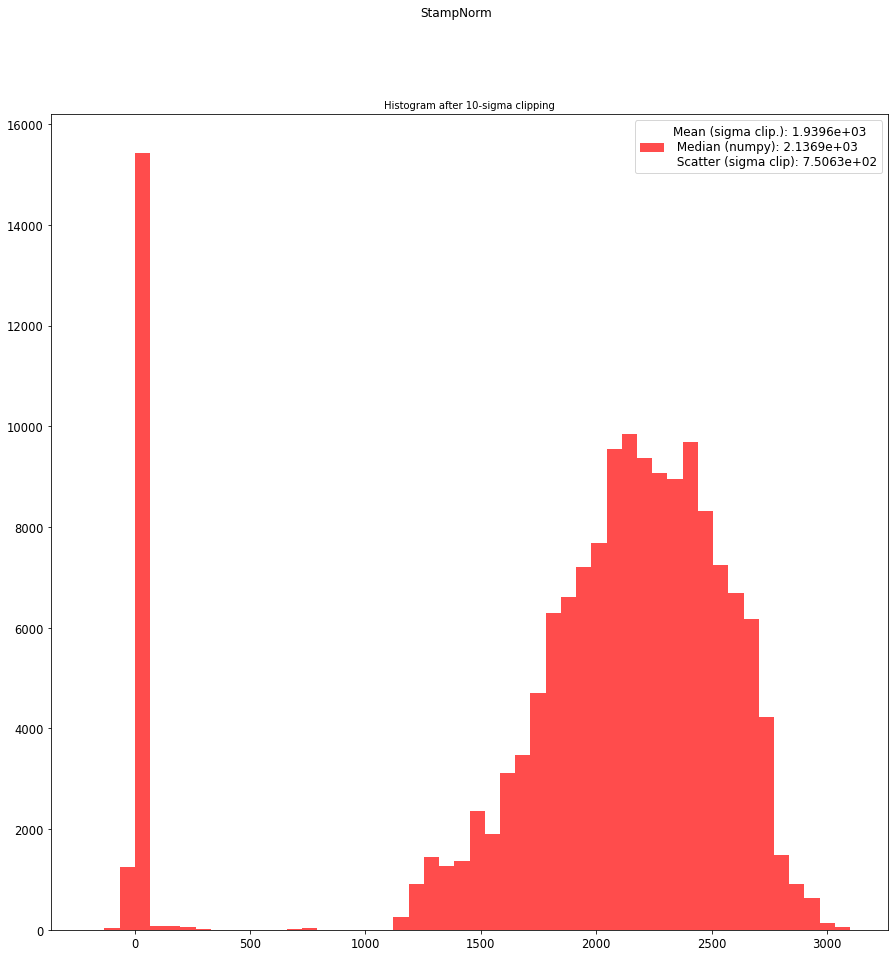

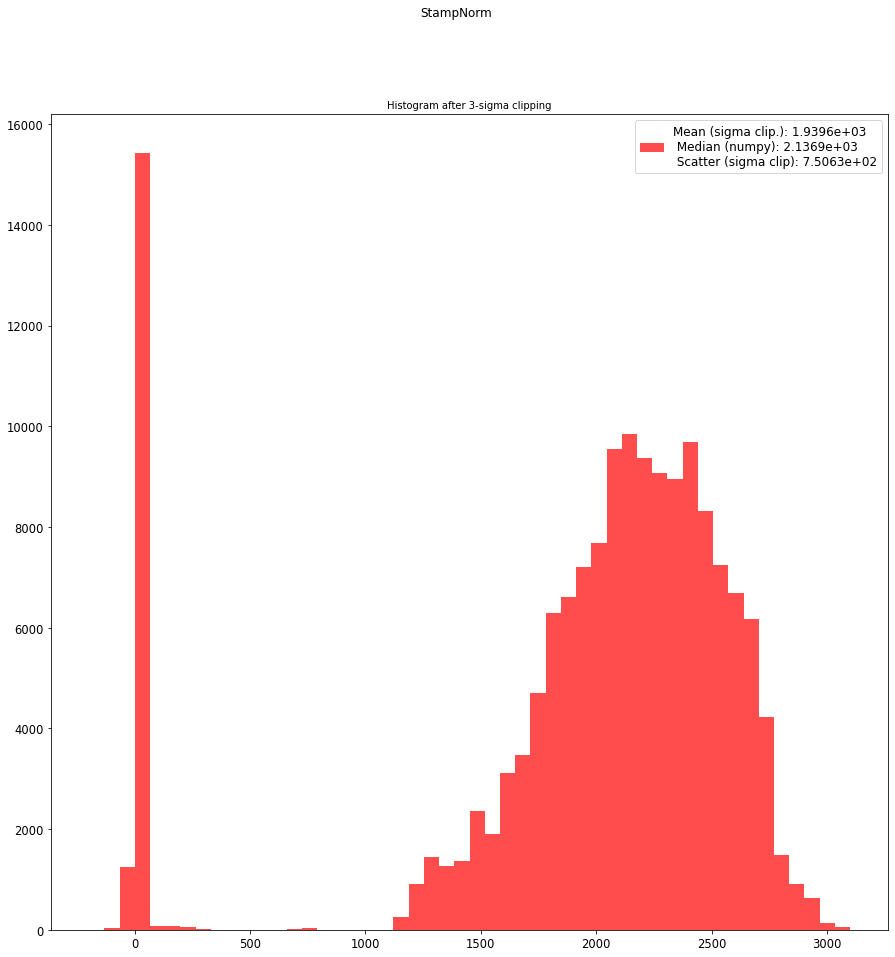

In [196]:
#allStampNorm  = np.nan_to_num(allStampNorm)
# Stamp normalization factor 
plotHistogram(allStampNorm, sigmaCut=10.0, title="StampNorm")
plotHistogram(allStampNorm, sigmaCut=3.0, title="StampNorm")

In [ ]:
## END